<a href="https://colab.research.google.com/github/yeabwang/malaria-diagnosis/blob/main/Malaria_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This model os a binary classification model which classifies cells as infected or not infected.
# Dataset to be used https://lhncbc.nlm.nih.gov/LHC-downloads/downloads.html#malaria-datasets
##### 27,558 cell images - from thin blood smear slides - contains both infected and uninfected cells.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [ ]:
dataset,dataset_info = tfds.load('malaria',as_supervised=True,with_info=True, shuffle_files = True,split=['train'])

In [ ]:
# Spliting our dataset into trianing, validation and testing

def split_dataset(dataset,train_ratio,val_ratio,test_ratio):
    dataset_size = len(dataset)

    train_dataset = dataset.take(int(train_ratio*dataset_size))  #grabbing our training dataset
    val_test_dataset = dataset.skip(int(train_ratio*dataset_size)) #grabbing the data left from the training dataset
    val_dataset = val_test_dataset.take(int(val_ratio*dataset_size)) #grabbing the validation set
    test_dataset = val_test_dataset.skip(int(val_ratio*dataset_size)) #grabbing the test dataset

    return train_dataset,val_dataset,test_dataset


In [ ]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

train_dataset,val_dataset,test_dataset = split_dataset(dataset[0],train_ratio,val_ratio,test_ratio)
# print(list(train_dataset.take(1).as_numpy_iterator())), list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator())

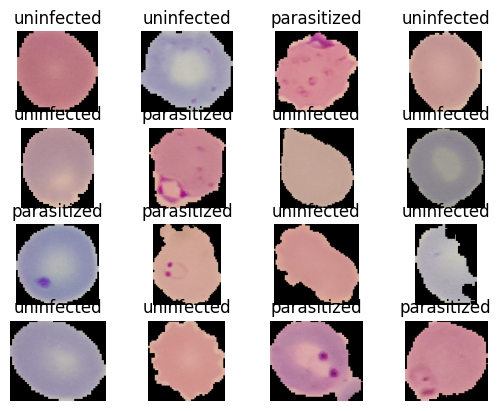

In [ ]:
# Ploting some of the datas we have in our datset
for i,(image,label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4,4,i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [ ]:
# Data Pre-processing
# We can choose between normalization and standardization as a method.
# If we are dealing with a data that revolves around a certain mean value we can then go for taking the standardization method.
# In standardization, we will deduct the value from the mean and then divide it with the standard diviation.

# If we are dealing with a data which varies alot, we should chose a normalization as it helps us round down the values in certain range.
# normalization is deducting the current value from the min value and then divide the result with the difference between the max and the min value.

# Here we will be using normalization

In [ ]:
# Resizing and Rescaling

image_size = 224

def resize_rescale(image,label):
  return tf.image.resize(image,[image_size,image_size])/255.0,label

train_dataset = train_dataset.map(resize_rescale)

In [ ]:
#shuffling and taking a batch of our dataset

train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)